# Hello, many worlds

In [1]:
import tensorflow as tf
import tensorflow_quantum as tfq

import cirq
import numpy as np
import sympy

%matplotlib inline
from matplotlib import style
style.use('bmh')
style.use('dark_background')

import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit
import pydot, graphviz

### The basics

In [2]:
a, b = sympy.symbols('a b')

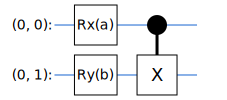

In [3]:
q0, q1 = cirq.GridQubit.rect(1, 2)

circuit = cirq.Circuit(
                    cirq.rx(a).on(q0),
                    cirq.ry(b).on(q1), cirq.CNOT(q0, q1))

SVGCircuit(circuit)
# print(circuit)

In [4]:
resolver = cirq.ParamResolver({a : 0.5, b : -0.5})
output_state_vector = cirq.Simulator().simulate(circuit, resolver).final_state
output_state_vector

array([ 0.9387913 +0.j        , -0.23971277+0.j        ,
        0.        +0.06120872j,  0.        -0.23971277j], dtype=complex64)

In [5]:
z0 = cirq.Z(q0)

qubit_map = {q0 : 0, q1 : 1}

z0.expectation_from_wavefunction(output_state_vector, qubit_map).real

0.8775825500488281

In [6]:
z0x1 = 0.5 * z0 + cirq.X(q1)

z0x1.expectation_from_wavefunction(output_state_vector, qubit_map).real

-0.04063427448272705

In [7]:
circuit_tensor = tfq.convert_to_tensor([circuit])

print(circuit_tensor.shape)
print(circuit_tensor.dtype)

(1,)
<dtype: 'string'>


In [8]:
pauli_tensor = tfq.convert_to_tensor([z0, z0x1])
pauli_tensor.shape

TensorShape([2])

### Batching circuit simulation

In [9]:
batch_vals = np.array(np.random.uniform(0, 2 * np.pi, (5, 2)), dtype=np.float32)

In [10]:
cirq_results = []
cirq_simulator = cirq.Simulator()

for vals in batch_vals:
    resolver = cirq.ParamResolver({a : vals[0], b : vals[1]})
    final_state = cirq_simulator.simulate(circuit, resolver).final_state
    cirq_results.append(
        [z0.expectation_from_wavefunction(final_state, {
            q0 : 0,
            q1 : 1
        }).real])
    
print('cirq batch results: \n {}'.format(np.array(cirq_results)))

cirq batch results: 
 [[0.83953464]
 [0.44405019]
 [0.2281633 ]
 [0.99464834]
 [0.52329826]]


In [11]:
tfq.layers.Expectation()(circuit, symbol_names=[a, b], symbol_values=batch_vals, operators=z0)

<tf.Tensor: shape=(5, 1), dtype=float32, numpy=
array([[0.83953476],
       [0.44405025],
       [0.2281632 ],
       [0.9946483 ],
       [0.52329826]], dtype=float32)>

# Hybrid Quantum-Classical Optimization

### Controlled circuit definition

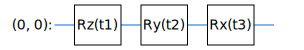

In [12]:
# Prameters which classical NN will feed values into
control_params = sympy.symbols('t1 t2 t3')

# Create the parameterized circuit
qubit = cirq.GridQubit(0, 0)
model_circuit = cirq.Circuit(
    cirq.rz(control_params[0])(qubit),
    cirq.ry(control_params[1])(qubit),
    cirq.rx(control_params[2])(qubit))

SVGCircuit(model_circuit)
# print(model_circuit)

### The controller

In [13]:
controller = tf.keras.Sequential([
    tf.keras.layers.Dense(10, activation='elu'),
    tf.keras.layers.Dense(3)
])

In [14]:
controller(tf.constant([[0.0], [1.0]])).numpy()

array([[ 0.        ,  0.        ,  0.        ],
       [-0.23752365, -0.09134974, -0.17483209]], dtype=float32)

### Connect the controller to the circuit

In [15]:
# This input is the simulated miscalibration that the model will learn to correct.
circuits_input = tf.keras.Input(shape=(),
                               dtype=tf.string, # circuit_tensor has dtype=tf.string
                               name='circuits_input')

# Commands will be either `0` or `1`, specifying the state to set the qubit to.
commands_input = tf.keras.Input(shape=(1,),
                                dtype=tf.dtypes.float32,
                                name='commands_input')

In [16]:
dense_2 = controller(commands_input)

# TFQ layer for classically controlled circuits
expectation_layer = tfq.layers.ControlledPQC(model_circuit,
                                            operators=cirq.Z(qubit))

expectation = expectation_layer([circuits_input, dense_2])

In [17]:
# The full Keras model is built from our layers.
model = tf.keras.Model(inputs=[circuits_input, commands_input],
                      outputs=expectation)

In [18]:
tf.keras.utils.plot_model(model, show_shapes=True, dpi=70)

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


### The dataset

In [19]:
# The command input values to classical NN
commands = np.array([[0], [1]], dtype=np.float32)

# The desired Z expectation value at outpu t of the quantum circuit
expected_outputs = np.array([[1], [-1]], dtype=np.float32)

### Input circuit definition

In [20]:
random_rotations = np.random.uniform(0, 2 * np.pi, 3)
noisy_prep = cirq.Circuit(
    cirq.rx(random_rotations[0])(qubit),
    cirq.ry(random_rotations[1])(qubit),
    cirq.rz(random_rotations[2])(qubit))

datapoint_circuits = tfq.convert_to_tensor([
    noisy_prep
] * 2) # Make two copies of this circuit

In [21]:
datapoint_circuits.shape

TensorShape([2])

### Training

In [22]:
model([datapoint_circuits, commands]).numpy()

array([[-0.5957383 ],
       [-0.58646244]], dtype=float32)

In [23]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.05)
loss = tf.keras.losses.MeanSquaredError()
model.compile(optimizer=optimizer, loss=loss)
history = model.fit(x=[datapoint_circuits, commands],
                    y=expected_outputs,
                    epochs=30,
                    verbose=1)

Train on 2 samples
Epoch 1/30
2/2 [==============================] - 1s 670ms/sample - loss: 1.3587
Epoch 2/30
2/2 [==============================] - 0s 2ms/sample - loss: 0.9834
Epoch 3/30
2/2 [==============================] - 0s 2ms/sample - loss: 0.6221
Epoch 4/30
2/2 [==============================] - 0s 1ms/sample - loss: 0.3341
Epoch 5/30
2/2 [==============================] - 0s 1ms/sample - loss: 0.1533
Epoch 6/30
2/2 [==============================] - 0s 2ms/sample - loss: 0.0641
Epoch 7/30
2/2 [==============================] - 0s 2ms/sample - loss: 0.0267
Epoch 8/30
2/2 [==============================] - 0s 2ms/sample - loss: 0.0116
Epoch 9/30
2/2 [==============================] - 0s 2ms/sample - loss: 0.0058
Epoch 10/30
2/2 [==============================] - 0s 2ms/sample - loss: 0.0042
Epoch 11/30
2/2 [==============================] - 0s 2ms/sample - loss: 0.0043
Epoch 12/30
2/2 [==============================] - 0s 2ms/sample - loss: 0.0045
Epoch 13/30
2/2 [===========

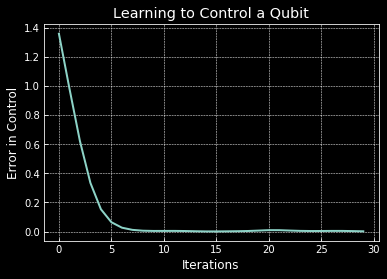

In [24]:
plt.plot(history.history['loss'])
plt.title("Learning to Control a Qubit")
plt.xlabel("Iterations")
plt.ylabel("Error in Control")
plt.show()

### Verify outputs

In [25]:
def check_error(command_values, desired_values):
    """Based on the value in `command_value` see how well you could prepare
    the full circuit to have `desired_value` when taking expectation w.r.t. Z."""
    params_to_prepare_output = controller(command_values).numpy()
    full_circuit = noisy_prep + model_circuit
    
    # Test how well you can prepare a state to get the expectation
    # value in `desired_values`
    for index in [0, 1]:
        state = cirq_simulator.simulate(full_circuit,
                                       {s : v for (s, v) in zip(control_params, params_to_prepare_output[index])}
                                       ).final_state
        expectation = z0.expectation_from_wavefunction(state, {qubit : 0}).real
        
        print(f'For a desired output (expectation) of {desired_values[index]} with'
          f' noisy preparation, the controller\nnetwork found the following '
          f'values for theta: {params_to_prepare_output[index]}\nWhich gives an'
          f' actual expectation of: {expectation}\n')
        
check_error(commands, expected_outputs)

For a desired output (expectation) of [1.] with noisy preparation, the controller
network found the following values for theta: [ 2.0013022   4.23094    -0.16599931]
Which gives an actual expectation of: 0.9637539386749268

For a desired output (expectation) of [-1.] with noisy preparation, the controller
network found the following values for theta: [-0.92347455 -1.0410511  -0.19210549]
Which gives an actual expectation of: -0.9929053783416748



In [26]:
model([datapoint_circuits, commands])

<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[ 0.96375436],
       [-0.99290544]], dtype=float32)>

# Learning to prepare eigenstates of different operators

### New model definition

In [27]:
# Define inputs.
commands_input = tf.keras.layers.Input(shape=(1),
                                       dtype=tf.dtypes.float32,
                                       name='commands_input')
circuits_input = tf.keras.Input(shape=(),
                                # The circuit-tensor has dtype `tf.string` 
                                dtype=tf.dtypes.string,
                                name='circuits_input')
operators_input = tf.keras.Input(shape=(1,),
                                 dtype=tf.dtypes.string,
                                 name='operators_input')

In [28]:
# Define classical NN.
controller = tf.keras.Sequential([
    tf.keras.layers.Dense(10, activation='elu'),
    tf.keras.layers.Dense(3)
])

In [29]:
dense_2 = controller(commands_input)

# Since you aren't using a PQC or ControlledPQC you must append
# your model circuit onto the datapoint circuit tensor manually.
full_circuit = tfq.layers.AddCircuit()(circuits_input, append=model_circuit)
expectation_output = tfq.layers.Expectation()(full_circuit,
                                              symbol_names=control_params,
                                              symbol_values=dense_2,
                                              operators=operators_input)

# Contruct your Keras model.
two_axis_control_model = tf.keras.Model(
    inputs=[circuits_input, commands_input, operators_input],
    outputs=[expectation_output])

### The dataset

In [30]:
# The operators to measure, for each command.
operator_data = tfq.convert_to_tensor([[cirq.X(qubit)], [cirq.Z(qubit)]])

# The command input values to the classical NN.
commands = np.array([[0], [1]], dtype=np.float32)

# The desired expectation value at output of quantum circuit.
expected_outputs = np.array([[1], [-1]], dtype=np.float32)

### Training

In [31]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.05)
loss = tf.keras.losses.MeanSquaredError()

two_axis_control_model.compile(optimizer=optimizer, loss=loss)

history = two_axis_control_model.fit(
    x=[datapoint_circuits, commands, operator_data],
    y=expected_outputs,
    epochs=30,
    verbose=1)

Train on 2 samples
Epoch 1/30
2/2 [==============================] - 1s 293ms/sample - loss: 1.3097
Epoch 2/30
2/2 [==============================] - 0s 1ms/sample - loss: 0.9362
Epoch 3/30
2/2 [==============================] - 0s 1ms/sample - loss: 0.5553
Epoch 4/30
2/2 [==============================] - 0s 1ms/sample - loss: 0.2600
Epoch 5/30
2/2 [==============================] - 0s 1ms/sample - loss: 0.1199
Epoch 6/30
2/2 [==============================] - 0s 1ms/sample - loss: 0.0929
Epoch 7/30
2/2 [==============================] - 0s 1ms/sample - loss: 0.1186
Epoch 8/30
2/2 [==============================] - 0s 2ms/sample - loss: 0.1770
Epoch 9/30
2/2 [==============================] - 0s 1ms/sample - loss: 0.2077
Epoch 10/30
2/2 [==============================] - 0s 2ms/sample - loss: 0.1858
Epoch 11/30
2/2 [==============================] - 0s 1ms/sample - loss: 0.1315
Epoch 12/30
2/2 [==============================] - 0s 1ms/sample - loss: 0.0747
Epoch 13/30
2/2 [===========

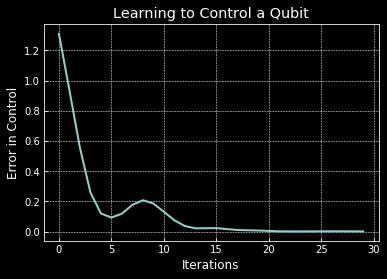

In [32]:
plt.plot(history.history['loss'])
plt.title("Learning to Control a Qubit")
plt.xlabel("Iterations")
plt.ylabel("Error in Control")
plt.show()

In [35]:
controller.predict(np.array([0,1]))

array([[ 2.679348  , -0.4228346 ,  0.36209983],
       [ 3.813424  , -2.719168  ,  3.995017  ]], dtype=float32)